# Проект 2: Моделирование динамики кривой бескупонной доходности

### Библиотеки

In [1]:
!pip install dash
!pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [4]:
from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/RM_project/'
file_name = 'КБД.xlsx'

Mounted at /content/drive


In [5]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x7EFDB5D4B740

In [7]:
from stoch_models import *
from data_stats import reduce_with_pca, plot_explained_variance, plot_corr

## Данные

Кривая бескупонной доходности на разные сроки: http://www.cbr.ru/hd_base/zcyc_params/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2015&UniDbQuery.To=31.12.2022

Данные собраны с января 2003 по май 2023.

In [8]:
zcc_data = pd.read_excel(folder+file_name)

In [9]:
data = zcc_data.set_index('Date')

rename_columns_1 = {'peroid_0.25':'КБД 0.25', 'peroid_0.5':'КБД 0.5', 'peroid_0.75':'КБД 0.75', 'peroid_1':'КБД 1',
                    'peroid_2':'КБД 2', 'peroid_3':'КБД 3', 'peroid_5':'КБД 5', 'peroid_7':'КБД 7',
                    'peroid_10':'КБД 10', 'peroid_15':'КБД 15', 'peroid_20':'КБД 20', 'peroid_30':'КБД 30'}

data.rename(columns=rename_columns_1, inplace=True)

col_list = ['КБД 0.25', 'КБД 0.5', 'КБД 0.75', 'КБД 1', 'КБД 2', 'КБД 3', 'КБД 5',
       'КБД 7', 'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30']

data['year'] = data.index.year

In [10]:
data.head(5)

,КБД 0.25,КБД 0.5,КБД 0.75,КБД 1,КБД 2,КБД 3,КБД 5,КБД 7,КБД 10,КБД 15,КБД 20,КБД 30,year
Date,,,,,,,,,,,,,
2003-01-04,11.68,12.31,12.76,13.08,13.63,13.72,13.63,13.53,13.45,13.38,13.35,13.32,2003
2003-01-05,11.09,11.70,12.16,12.50,13.14,13.30,13.31,13.27,13.23,13.20,13.19,13.17,2003
2003-01-08,10.84,11.61,12.15,12.53,13.18,13.30,13.29,13.24,13.19,13.15,13.13,13.11,2003
2003-01-09,10.46,11.13,11.67,12.09,13.02,13.31,13.38,13.32,13.25,13.19,13.16,13.13,2003
2003-01-10,10.10,11.08,11.79,12.28,13.14,13.31,13.27,13.19,13.11,13.04,13.00,12.97,2003


### Анализ

In [11]:
def get_mean(df, col_list):
    arr_mean = []
    for i in df.index:
        arr = df.loc[i][col_list].values
        arr_mean.append(np.mean(arr))
    return arr_mean

In [12]:
# Стандартизация данных
data_st = deepcopy(data)

# Вычитаем среднее и делим на стандартное отклонение
for i in col_list:
    mean_ = np.mean(data_st[i])
    std_ = np.std(data_st[i])
    data_st[i] = (data_st[i] - mean_) / std_

data_st['Среднее'] = get_mean(data_st , col_list)

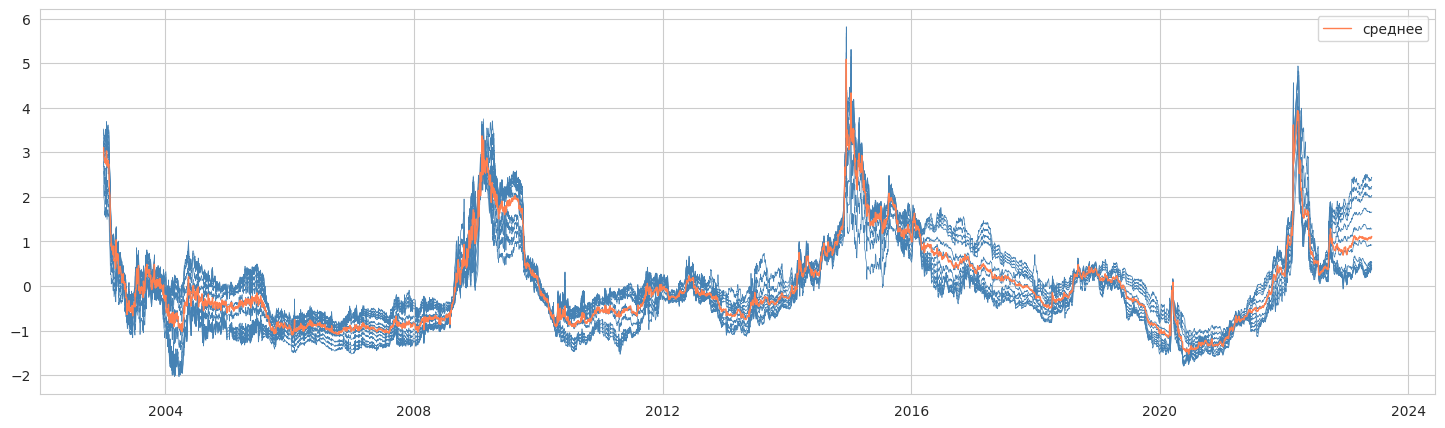

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5))
for i in col_list:
    axs.plot(data_st[i], linewidth=0.5, color='steelblue')
axs.plot(data_st['Среднее'], linewidth=1, color='coral', label='среднее')
axs.legend()
plt.show()

## PCA

In [14]:
def plot_pca(df, n_comp = 3,
             return_df=0,
             plot=1, mean_=1, title=None, fig_size=(18, 6)):

    reduced, pca = reduce_with_pca(df, fraction=n_comp)

    if plot == 1:
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for i in range(reduced.shape[1]):
            axs.plot(df.index, reduced[:, i], linewidth=0.7, label = f'component {i+1}')
        mean_val = get_mean(df, df.columns)
        axs.plot(df.index, mean_val, label = 'Среднее', color='gray', linestyle='--', linewidth=0.5)
        axs.legend()
        if title is not None:
            axs.set_title(title)
        plt.show()
    if return_df == 1:
        df_res = pd.DataFrame(data=reduced, index = df.index)
        df_res.columns = [f'component {i+1}' for i in range(0, n_comp)]
        return df_res

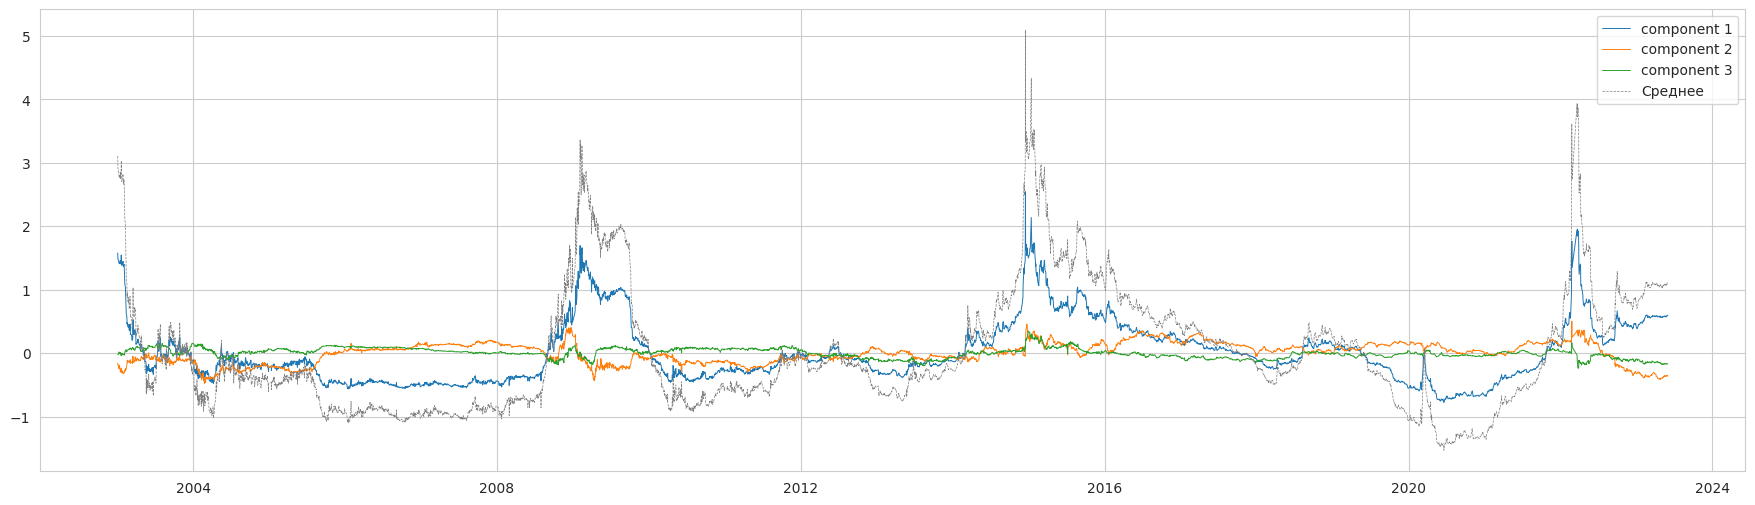

In [15]:
plot_pca(data_st[col_list], fig_size=(22, 6))

# Моделирование

In [20]:
def split_data(df, split_date=None, start_date=None, end_date=None, with_val=False, val_size=0, test_size=1):
    if with_val:
        df_train = df.iloc[:-(val_size+test_size)]
        df_valid = df.iloc[-(val_size+test_size):-test_size]
        df_test = df.iloc[-test_size:]
        return df_train, df_valid, df_test
    else:
        train = df[df.Date <= split_date]
        test = df[df.Date > split_date]
        if start_date is not None:
            train = train[train.Date >= start_date]
        if end_date is not None:
            test = test[test.Date <= end_date]
        return train, test

### Стохастические модели

In [16]:
data.reset_index(inplace=True)

In [17]:
df_pca = plot_pca(data[col_list], return_df=1, plot=0)
df_pca['Date'] = data['Date']

In [18]:
df_pca.head(5)

,component 1,component 2,component 3,Date
0,1.578336,-0.156012,-0.022947,2003-01-04
1,1.480359,-0.189722,-0.023547,2003-01-05
2,1.467460,-0.189378,-0.012553,2003-01-08
3,1.441733,-0.239067,0.005431,2003-01-09
4,1.416596,-0.217494,0.021618,2003-01-10


In [22]:
df_train_all, df_test_all = split_data(data, split_date='2023-01-01')
print(df_train_all.shape[0], df_test_all.shape[0])

5074 103


#### КБД со сроком погашения 1 год

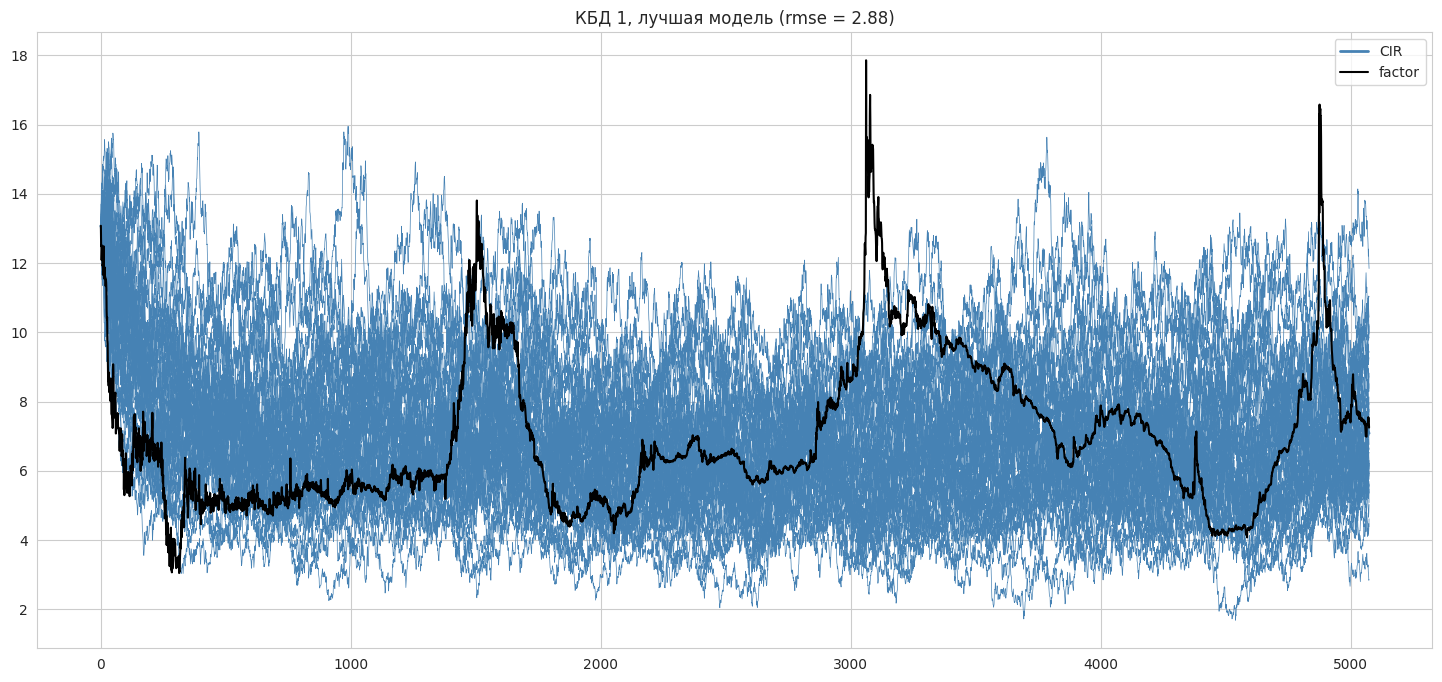

In [26]:
f_col = 'КБД 1'
sm = Stoch_Models(factor_name=f_col,
                  value_train = df_train_all[f_col].values, value_test = df_test_all[f_col].values,
                  t_train = list(df_train_all.index), t_test = list(df_test_all.index),
                  models=['m1', 'm2', 'm3'], N_traj=50)
sm.choose_model(print_metric=0, plot_all=0, metric='rmse')

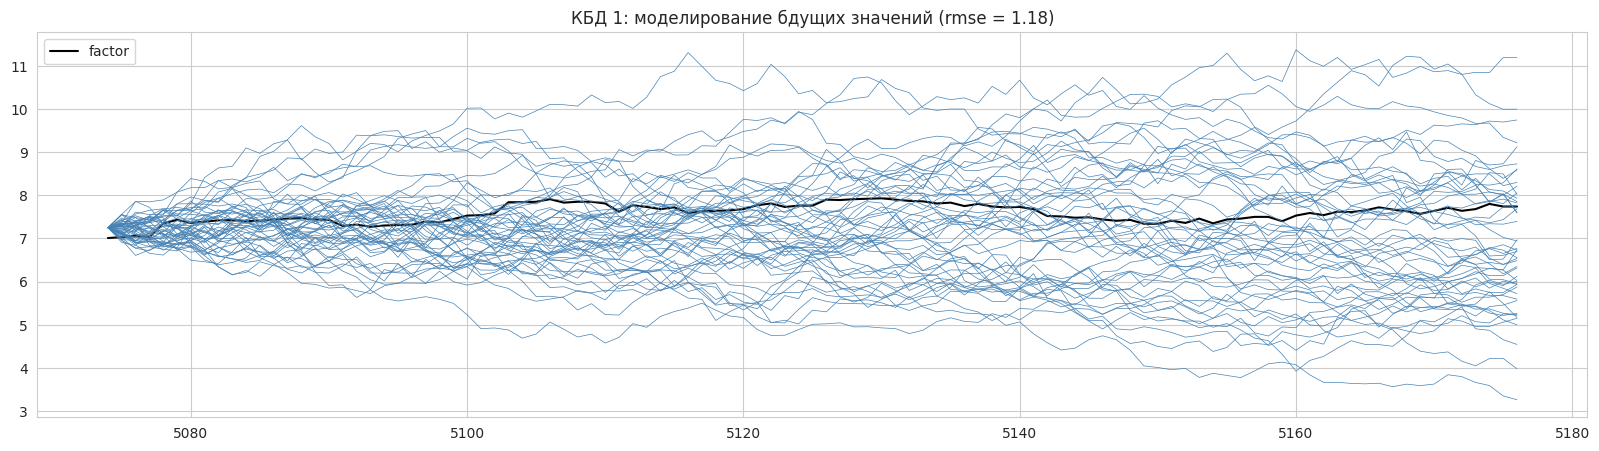

In [27]:
res1 = sm.future_simulation(plot=1)

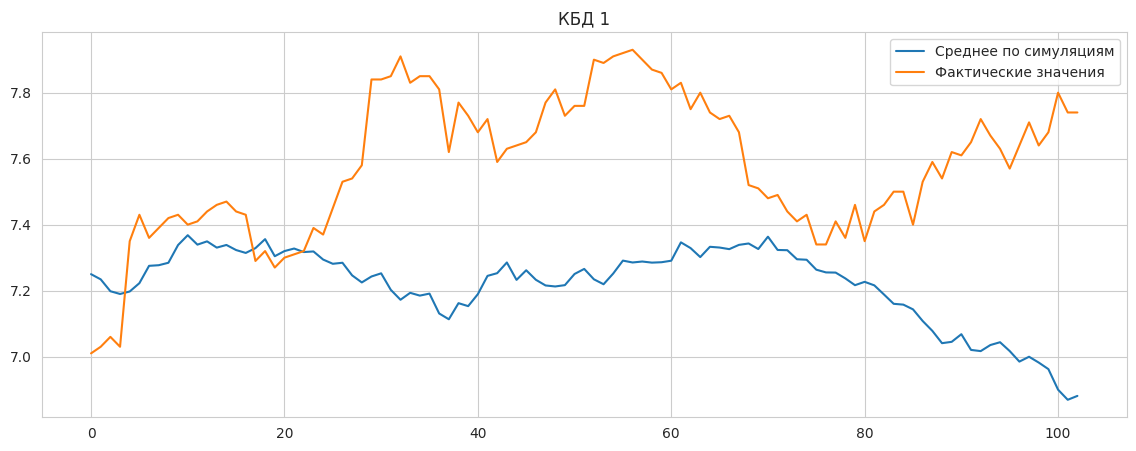

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(14, 5))

axs.plot(np.mean(res1, axis=0), label = 'Среднее по симуляциям')
axs.plot(df_test_all[f_col].values, label = 'Фактические значения')

axs.set_title(f_col)
axs.legend()
plt.show()

#### КБД со сроком погашения 10 лет

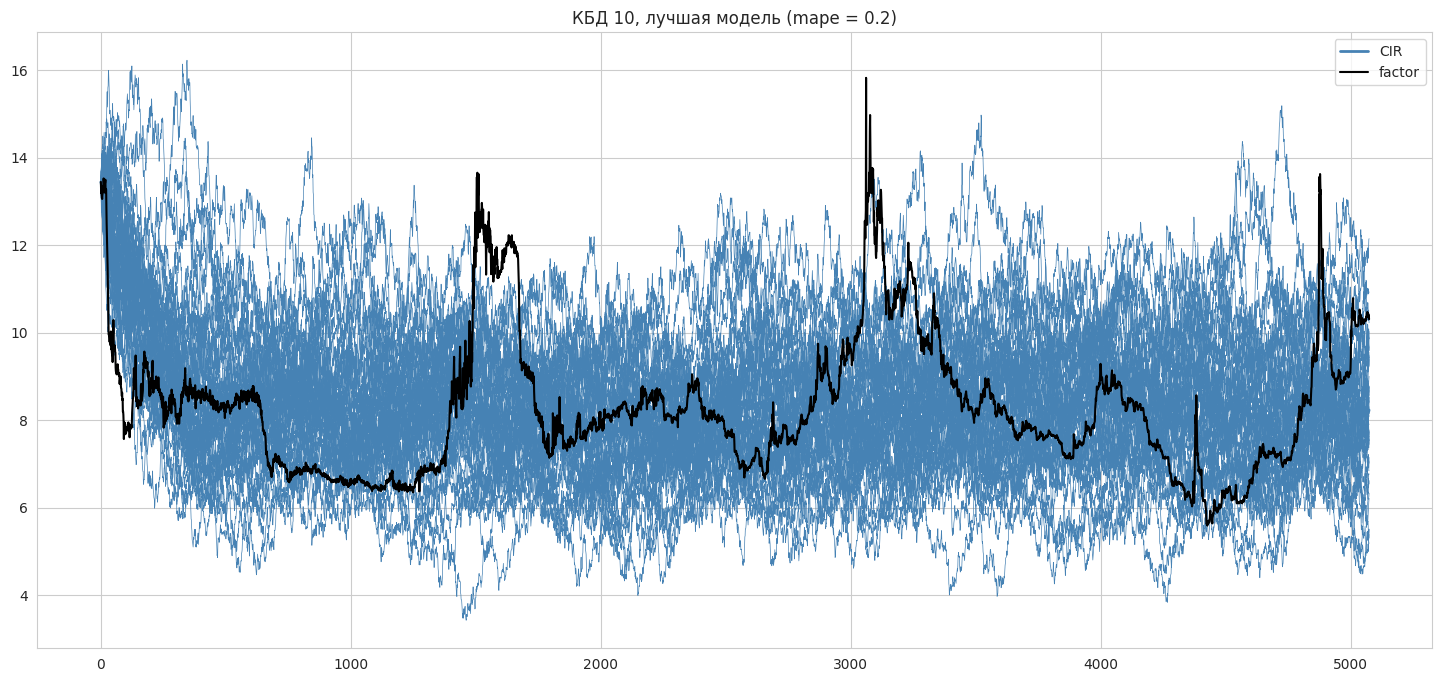

In [29]:
f_col = 'КБД 10'
sm = Stoch_Models(factor_name=f_col,
                  value_train = df_train_all[f_col].values, value_test = df_test_all[f_col].values,
                  t_train = list(df_train_all.index), t_test = list(df_test_all.index),
                  models=['m1', 'm2', 'm3'], N_traj=50)
sm.choose_model(print_metric=0, plot_all=0, metric='mape')

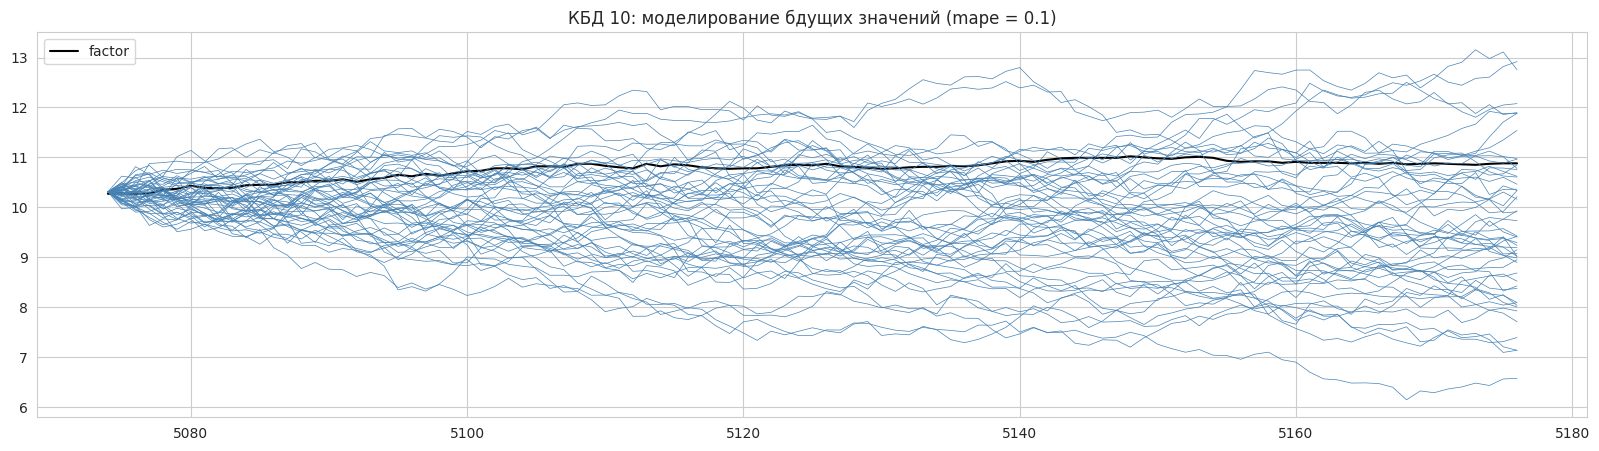

In [30]:
res2 = sm.future_simulation(plot=1)

### Результат

In [32]:
res_mean_sim = {}

for c_ in col_list:
    sm = Stoch_Models(factor_name=c_,
                  value_train = df_train_all[c_].values, value_test = df_test_all[c_].values,
                  t_train = list(df_train_all.index), t_test = list(df_test_all.index),
                  models=['m1', 'm2', 'm3'], N_traj=50)
    sm.choose_model(print_metric=0, plot_all=0, plot_best=0, metric='mape')
    res_ = sm.future_simulation(plot=0)
    res_mean_sim[c_] = np.mean(res_, axis=0)

In [33]:
final_df = pd.DataFrame(index = df_test_all.index)
for i in res_mean_sim.keys():
    final_df[i] = res_mean_sim[i]

In [34]:
final_df.head(5)

,КБД 0.25,КБД 0.5,КБД 0.75,КБД 1,КБД 2,КБД 3,КБД 5,КБД 7,КБД 10,КБД 15,КБД 20,КБД 30
5074,6.680000,6.870000,7.060000,7.250000,7.950000,8.520000,9.370000,9.890000,10.310000,10.630000,10.820000,11.040000
5075,6.670165,6.928690,7.045215,7.258732,7.969533,8.496395,9.382821,9.876748,10.290735,10.597911,10.815881,11.024479
5076,6.653014,6.875995,7.034057,7.250446,7.929469,8.553319,9.370328,9.855287,10.293471,10.569776,10.827260,11.000536
5077,6.620183,6.867599,7.041073,7.212178,7.939407,8.535858,9.350632,9.854262,10.275505,10.548045,10.818423,11.006762
5078,6.650709,6.846965,7.020014,7.228674,7.959324,8.510209,9.290004,9.813431,10.258543,10.499968,10.775680,11.001501


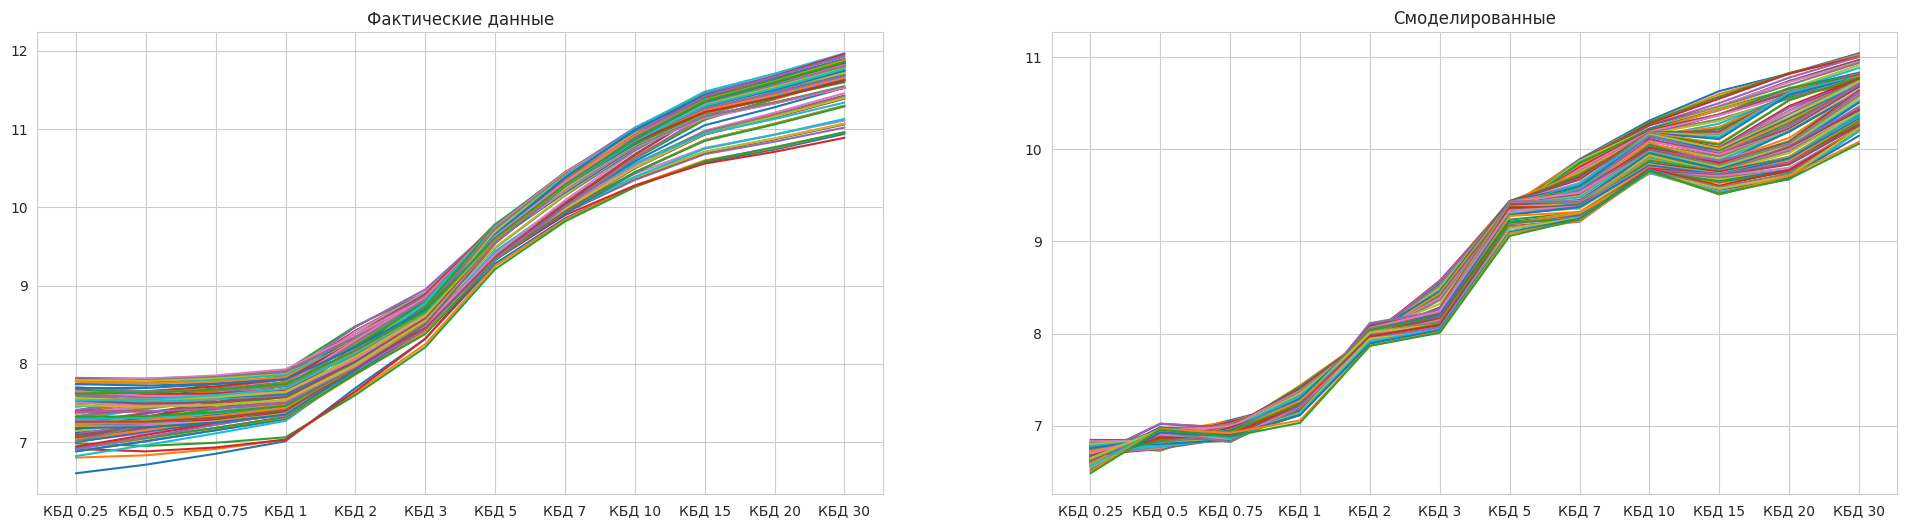

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

for i in df_test_all.index:
    axs[0].plot(col_list, data.loc[i][col_list].values)
axs[0].set_title('Фактические данные')

for i in df_test_all.index:
    axs[1].plot(col_list, final_df.loc[i][col_list].values)
axs[1].set_title('Смоделированные')

plt.show()

In [ ]:
df_ = pd.DataFrame(index=col_list, column=['fact', 'forecast'])
df_['fact'] = df_test_all.loc[ind_][col_list].values
df_['forecast'] = l.loc[ind_][col_list].values

In [42]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
from datetime import date
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Кривая бескупонной доходности'),
    dcc.Graph(id="time-series-chart"),
    html.P("Выбрать дату:"),
    dcc.DatePickerSingle(
        id='my-date-picker-single',
        min_date_allowed=date(2023, 1, 3),
        max_date_allowed=date(2023, 5, 31),
        initial_visible_month=date(2023, 1, 3),
        date=date(2023, 1, 3)
    )
])

@app.callback(
    Output("time-series-chart", "figure"),
    # Input("date", "value")
    Input("my-date-picker-single", "date")
)
def display_time_series(date):
    ind_ = df_test_all[df_test_all.Date == date].index[0]
    fig = px.line(df_test_all[col_list].T, x=col_list, y=final_df.loc[ind_][col_list].values, title=f'{date} forecast')
    return fig

app.run_server(debug=True)

<IPython.core.display.Javascript object>

### SARIMA (не очень удачно)

In [43]:
warnings.filterwarnings('ignore')

def best_parametrs_sarimax(train_ser, valid_ser, param_grid, freq, metric='mape'):
    best_m = float("inf")
    results = []

    param_grid_list = list(ParameterGrid(param_grid))
    for param in tqdm(param_grid_list):
        try:
            model = sm.tsa.statespace.SARIMAX(train_ser, order=(param['p'], param['d'], param['q']),
                            seasonal_order=(param['p_s'], param['d_s'], param['q_s'], freq)).fit(disp=-1)
        except:
            continue

        val_forecast = model.forecast(len(valid_ser))
        m = calculate_metric(valid_ser, [val_forecast], mode=metric)
        print(m)
        if m < best_m:
            best_m = m
            results.append({'parametrs':param, 'forecast':val_forecast, 'metric':m})

    # последняя добавленная модель будет иметь наименьшее значение
    if len(results) != 0:
        return results[-1]
    else:
        print('ARIMA: parametrs not found')
        return None

In [44]:
def forecast_sarimax(ser, n_step, best_params, freq=7):
    try:
        best_model = sm.tsa.statespace.SARIMAX(ser, order=(best_params['p'], best_params['d'], best_params['q']),
                            seasonal_order=(best_params['p_s'], best_params['d_s'], best_params['q_s'], freq)).fit(disp=-1)
        data_forecast = best_model.forecast(n_step)
        return data_forecast
    except:
        return None

In [46]:
train_data, valid_data, test_data = split_data(df_pca, with_val=True, val_size=60, test_size=103)

f_ = 'component 1'
train_ser, valid_ser, test_ser = train_data[f_].values, valid_data[f_].values, test_data[f_].values

print(len(train_ser), len(valid_ser), len(test_ser))

5014 60 103


In [47]:
arima_grid = {'p': list(range(0, 5)),
                  'd': [0, 1, 2],
                  'q': list(range(0, 5)),
                  'p_s': list(range(0, 5)),
                  'd_s': [0, 1, 2],
                  'q_s': list(range(0, 5))}

best_param_1 = best_parametrs_sarimax(train_ser, valid_ser, param_grid=arima_grid, freq=30, metric='mape')

  0%|          | 0/5625 [00:00<?, ?it/s]

ARIMA: parametrs not found


In [ ]:
#arima_res = forecast_sarimax(test_ser, n_step=test_data.shape[0], best_params=best_param_1)
#if arima_res is not None:
#    arime_metric = get_metric(test_ser, arima_res, mode=metric)